In [1]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')


In [2]:
def get_and_store_raw_data(fromCSV, numberOfStocks=50, daysSince=30):
    tickers_df = retrieve.get_tickers(10)
    if (fromCSV):
        print ("Returning stored data.")
        (rawdata, spreads, volumes) = ((pd.read_csv('data/close.csv')).set_index('Date'),
                            (pd.read_csv('data/spreads.csv')).set_index('Date'),
                            (pd.read_csv('data/volumes.csv')).set_index('Date'))
    else:
        downloadedData = retrieve.get_downloaded_data(tickers_df, numberOfStocks, daysSince)
        rawdata = downloadedData['Close']
        spreads = (downloadedData['High'] - downloadedData['Low'])/(downloadedData['Close'])
        volumes = downloadedData['Volume']
        rawdata.to_csv('./data/close.csv')
        spreads.to_csv('./data/spreads.csv')
        volumes.to_csv('./data/volumes.csv')

    return (rawdata, spreads, volumes, tickers_df)
    
def processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    
    companies = closes.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(closes.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(closes, keyStats, 3)

    return(EMA_df, OBV_df, keyStats) 

import matplotlib.pyplot as plt

def plot_one_with_obv(x, EMA_df, closes, OBV_df):
    fig, axs = (plt.subplots(2, sharex=True))
    x_axis = closes.index
    axs[0].plot(x_axis, EMA_df['Quick'][x], 'r')
    axs[0].plot(x_axis, EMA_df['Slow'][x], 'b')
    axs[0].plot(x_axis, closes[x], 'g')
    axs[1].plot(x_axis, OBV_df[x], 'g')

def showData(closes, EMA_df, OBV_df, keyStats, filterSet, tickers_df):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(closes, EMA_df, OBV_df, filteredCompanies, tickers_df, limit=10)



In [3]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     })



def find_stocks(filterSet, numberOfStocks=50):
    (closes, spreads, volumes, tickers_df)= get_and_store_raw_data(fromCSV='keyStats' in globals(), numberOfStocks=numberOfStocks, daysSince=30)
    (EMA_df, OBV_df, keyStats) = processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2)
    showData(closes, EMA_df, OBV_df, keyStats, filterSet, tickers_df)
    return (closes, spreads, volumes, EMA_df, keyStats, tickers_df)

#(closes, spreads, EMA_df, keyStats) = find_stocks(filterSet)



In [4]:
(ts_today, ts_origin) = retrieve.get_timestamps(2)

Requested days: 30.
Requested stocks: 50.
[*********************100%***********************]  10 of 10 completed
EMA Dataframe calculated.
Intersection points found.
Absolute and Relative Mins calculated.
Main companies filtered. 9 outstanding companies.
Displaying 9 first companies
Company AAP
Company ABBV
Company ABT
Company ADBE
Company ADM
Company ADP
Company AOS
Company ATVI
Company MMM


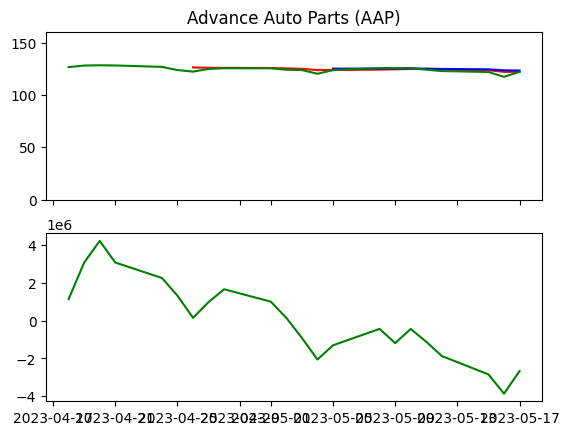

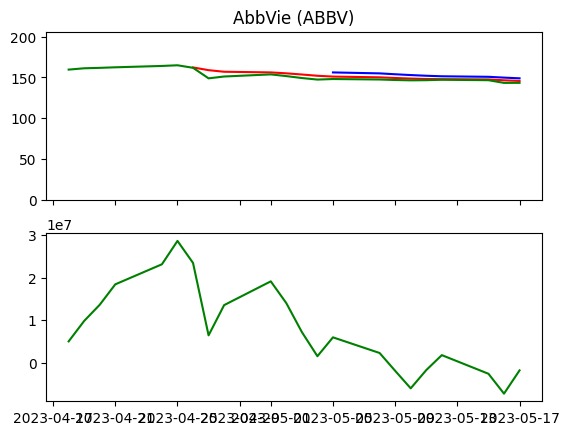

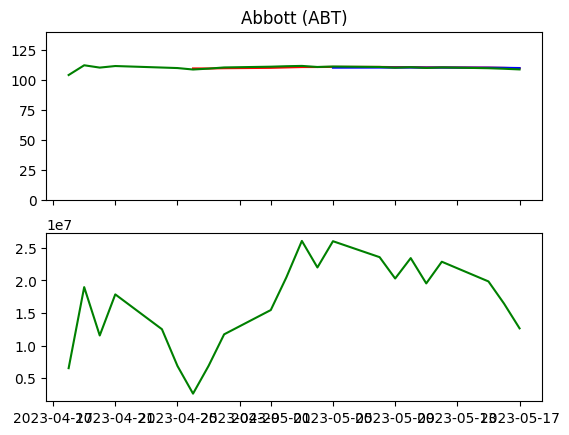

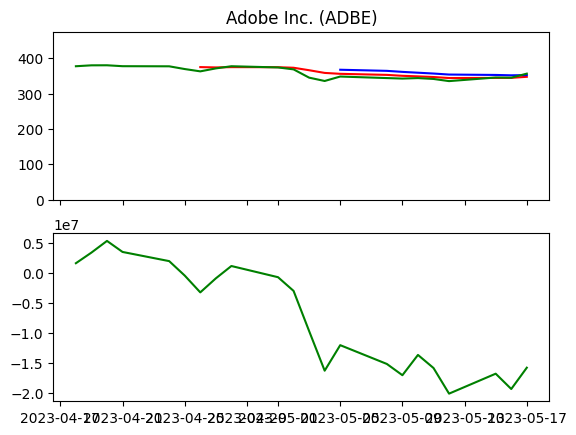

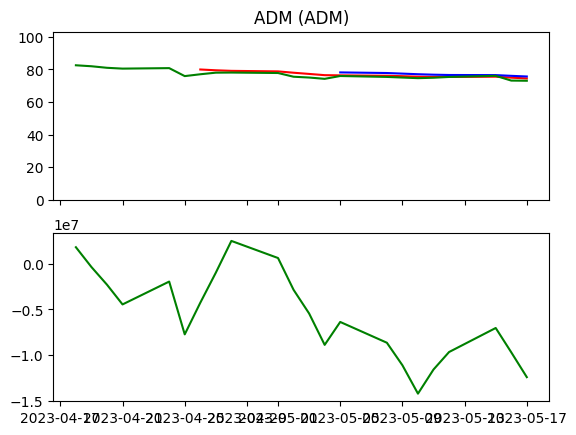

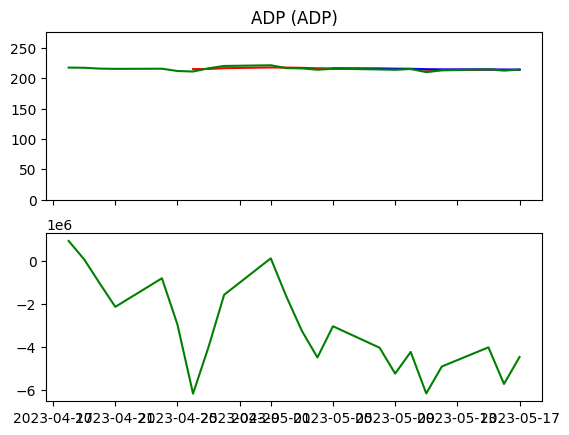

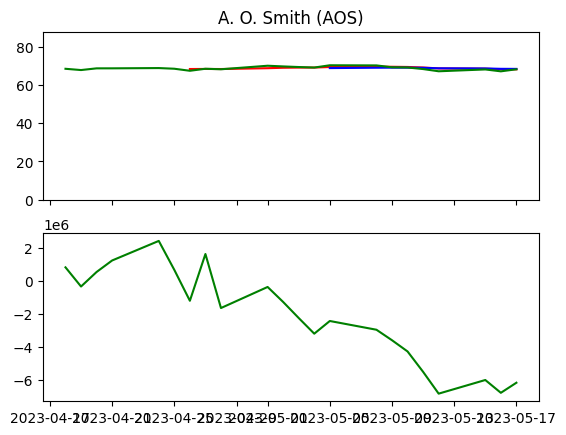

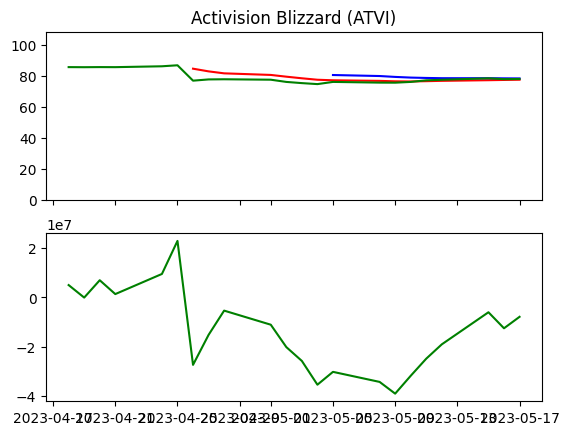

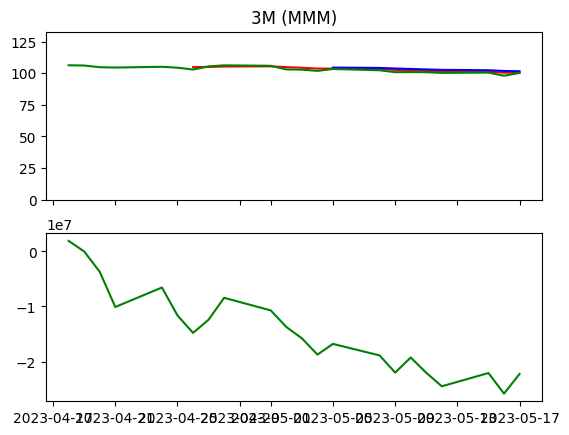

In [5]:
#if 'keyStats' in globals(): del(keyStats)
(closes, spreads, volumes, EMA_df, keyStats, tickers_df) = find_stocks(dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0, #Originally 0.0001 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":-5 #Originally 0.005
     }))

In [6]:
OBV_df= calc.get_OBV_df(volumes, closes)